# Tutorial

In this tutorial, we'll simulate a simple 2D localization problem as per the figure below. We'll assume that we have a robot following a typical bicycle model, which has access to noisy measurements of its forward velocity $v$ and angular velocity $\omega$. In addition, this robot will have a time-of-flight sensor that gives it range measurements to a few known landmarks in the environment. 

INSERT DIAGRAM HERE


## Traditional approach
The first step is to define the state of the robot. We'll start with a more traditional approach and define the state of the robot to be a vector of the form $\mathbf{x} = [\theta, x, y ]$, where $x$ and $y$ are the robot's position in the world and $\theta$ is its orientation. We'll also define the control inputs to be $\mathbf{u} = [\omega, v]$, the robot's forward and angular velocity. The process (motion) model of the robot is then given by:

$$
\begin{aligned}
    \dot{\theta} &= \omega,\\
    \dot{x} &= v \cos(\theta), \\
    \dot{y} &= v \sin(\theta). 
\end{aligned}
$$

However, this is in continuous time, and we need to discretize it to use it in a filter. For now, we'll use the simple Euler discretization method, which gives us the following discrete-time process model:

$$
\begin{aligned}
    \theta_{k+1} &= \theta_k + \omega_k \Delta t, \\
    x_{k+1} &= x_k + v_k \cos(\theta_k) \Delta t, \\
    y_{k+1} &= y_k + v_k \sin(\theta_k) \Delta t.
\end{aligned}
$$

Lets now code up our state and process model using navlie's framework. Since our state is just a regular 3x1 vector, we can use a standard type from the built-in library: `navlie.lib.VectorState` 


In [1]:
import numpy as np
np.random.seed(0)
import navlie as nav
from navlie.lib import VectorState

x = VectorState([0, 0, 0], stamp=0.0)
print(x)

VectorState(stamp=0.0, dof=3, state_id=None)
    [0. 0. 0.]


The `VectorState` is a subclass of the abstract `State` class in navlie, which is one of the core primitive types. The value of the state is stored as a numpy array, and can be accessed directly through `x.value`. 

For the process model, we'll choose to define our own from scratch here. Process models in navlie *must* inherit from the abstract `navlie.ProcessModel` class and implement the `evaluate` and either the `input_covariance` or `covariance` methods.

In [2]:
from navlie.lib import VectorInput

Q = np.eye(2) * 0.1**2 # Input noise covariance with 0.1 m/s of standard deviation

class BicycleModel(nav.ProcessModel):
    def evaluate(self, x: VectorState, u: nav.VectorInput, dt: float) -> VectorState:
        x_next = x.copy()
        x_next.value[0] += u.value[0] * dt
        x_next.value[1] += u.value[1] * dt * np.cos(x.value[0])
        x_next.value[2] += u.value[1] * dt * np.sin(x.value[0])
        return x_next

    def input_covariance(self, x: VectorState, u: VectorInput, dt: float) -> np.ndarray:
        return Q
    
process_model = BicycleModel() # instantiate it

The methods in navlie process models must always accept the arguments shown above: a `State` object, an `Input` object, and a float `dt`. The `evaluate` method must always return a valid (i.e. subclass) `State` object, and the `input_covariance` method must always return a square numpy array. There are more optional methods that can be implemented for performance reasons, but we will cover those later.

Moving on to the measurement model, if $\mathbf{r} = [x,y]$ denotes the position vector of the robot in the world frame, and $\mathbf{\ell}_i \in \mathbb{R}^2$ is the 2 x 1 position vector of landmark $i$, then the measurement model for each landmark is simply 

$$ 
y_i = ||\mathbf{r} - \mathbf{\ell}_i||
$$

In navlie, measurement models must be implemented in a similar way to process models: inherit from the `navlie.MeasurementModel` abstract class, and then implement the `evaluate` and `covariance` methods. Here's an example for this problem:

In [3]:
class RangeToLandmark(nav.MeasurementModel):
    def __init__(self, landmark_position: np.ndarray):
        self.landmark_position = landmark_position

    def evaluate(self, x: VectorState) -> np.ndarray:
        return np.linalg.norm(x.value[1:] - self.landmark_position)
    
    def covariance(self, x: VectorState) -> np.ndarray:
        return 0.1**2
    
landmarks = np.array([[1, 1], [1, 2], [2, 2], [2, 1]])
meas_models = [RangeToLandmark(landmark) for landmark in landmarks]

The next step is to generate some fake data for our simulation (although navlie is also compatible with real data). To do this, we will use the `DataGenerator` class which is used as follows

In [4]:
dg = nav.DataGenerator(
    process_model=process_model,                  # process model to use
    input_func=lambda t, x: np.array([0.3, 0.5]), # a callable that specifies the input values over time
    input_covariance= Q,                          # numpy array or callable that specifies the input covariance over time
    input_freq=50,                                # the frequency (Hz) at which the input is sampled (and the process model integrated)
    meas_model_list=meas_models,                  # a list of measurement models to use
    meas_freq_list=[10, 10, 10, 10]               # corresponding measurement frequencies (Hz)
)

state_data, input_data, meas_data = dg.generate(x, start=0, stop=10, noise=True)

print(state_data[0])
print(input_data[0])
print(meas_data[0])

VectorState(stamp=0.0, dof=3, state_id=None)
    [0. 0. 0.]
VectorInput(stamp=0.0, state_id=None)
    [0.4867558  0.40227221]
Measurement(stamp=0.0, state_id=None) of RangeToLandmark
    1.5906187969698615


The output of the `DataGenerator.generate` method is three lists: a list of ground-truth `State` objects, a list of `Input` objects, and a list of `Measurement` objects, with the input/measurement lists possibly being corrupted by random noise if the `noise=True` flag is set. Each item in these lists correspond to different points in time. We can plot the trajectory as follows

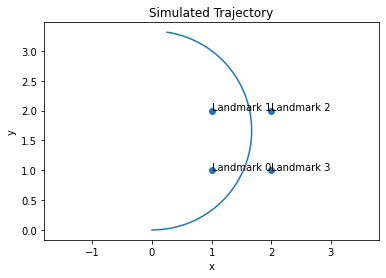

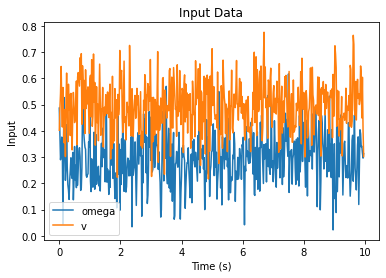

In [5]:
import matplotlib.pyplot as plt

# Plot the state trajectory
pos = np.array([state.value[1:] for state in state_data])
plt.plot(pos[:, 0], pos[:, 1])
plt.scatter(landmarks[:, 0], landmarks[:, 1])
# add labels
for i, landmark in enumerate(landmarks):
    plt.annotate(f"Landmark {i}", landmark)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Simulated Trajectory")
plt.axis("equal")


# Plot the input data
plt.figure()
u_array = np.array([u.value for u in input_data])
u_stamps = np.array([u.stamp for u in input_data])
plt.plot(u_stamps, u_array[:, 0], label="omega")
plt.plot(u_stamps, u_array[:, 1], label="v")
plt.xlabel("Time (s)")
plt.ylabel("Input")
plt.title("Input Data")
plt.legend()
plt.show()


Finally, lets run an extended Kalman filter on this data to get a state estimate that uses only the noisy measurements

In [6]:
# First, define the filter
kalman_filter = nav.ExtendedKalmanFilter(process_model)
P0 = np.diag([0.1**2, 1**2, 1**2])  # Initial covariance
x = nav.StateWithCovariance(x, P0)  # Estimate and covariance in one container

meas_idx = 0
y = meas_data[meas_idx]
estimates = []
for k in range(len(input_data) - 1):
    u = input_data[k]

    # Fuse any measurements that have occurred.
    while y.stamp < input_data[k + 1].stamp and meas_idx < len(meas_data):
        x = kalman_filter.correct(x, y, u)

        # Load the next measurement
        meas_idx += 1
        if meas_idx < len(meas_data):
            y = meas_data[meas_idx]

    # Predict until the next input is available
    dt = input_data[k + 1].stamp - x.state.stamp
    x = kalman_filter.predict(x, u, dt)

    estimates.append(x.copy())

The `GaussianResultList` object is a useful container for evaluating the quality of the state estimates when ground truth data is available. 

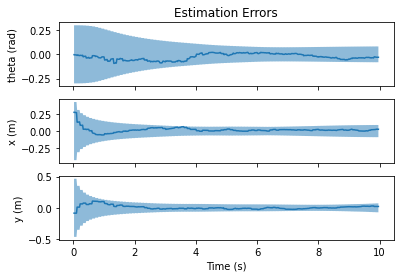

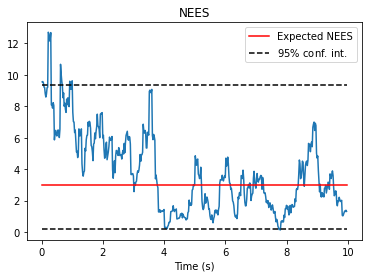

In [7]:
results = nav.GaussianResultList.from_estimates(estimates, state_data)

fig, axs = nav.plot_error(results)
axs[0].set_title("Estimation Errors")
axs[0].set_ylabel("theta (rad)")
axs[1].set_ylabel("x (m)")
axs[2].set_ylabel("y (m)")
axs[2].set_xlabel("Time (s)")

fig, ax = nav.plot_nees(results)
ax.set_title("NEES")
ax.set_xlabel("Time (s)")
plt.show()

## Lie group approach
Another way we could approach this state estimation task is to instead use Lie group theory, which is becoming increasingly common practice in state estimation. Lie group theory can be very abstract, and the main references that navlie refer to are the following:

1. [A micro Lie theory for state estimation in robotics](https://arxiv.org/abs/1812.01537)
2. [T.Barfoot, State Estimation for Robotics](http://asrl.utias.utoronto.ca/~tdb/bib/barfoot_ser17.pdf)


Instead of representing the state using a vector, we will represent the state using an element of the *special Euclidean group* $SE(2)$, sometimes called *pose transformation matrices*. Elements of this group are 3x3 matrices of the form 

$$ 
\mathbf{T} = \begin{bmatrix} \mathbf{C}(\theta) & \mathbf{r} \\ \mathbf{0} & 1 \end{bmatrix} \in SE(2)
$$

where $\mathbf{r} = [x,y]^T$ again denotes the position of the robot and $\mathbf{C}(\theta) \in SO(2)$ is a rotation matrix (sometimes called a direction cosine matrix) with the form 

$$ 
\mathbf{C}(\theta) = \begin{bmatrix} \cos \theta & - \sin \theta \\ \sin \theta & \cos \theta \end{bmatrix}.
$$

Unlike vectors, elements of $SE(2)$ cannot be added together to produce another valid element of $SE(2)$, but they can be multiplied together to do so. Key mathematical relationships are the exponential and logarithmic maps associated with $SE(2)$, which can be used to convert a 3x1 vector to an $SE(2)$ element and back, respectively.  These are often used to define the "oplus" and "ominus" operators as follows:

$$
\begin{aligned}
\mathbf{T}_2 &= \mathbf{T}_1 \oplus \mathbf{\xi} := \mathbf{T}_1 \exp(\boldsymbol{\xi}^\wedge)  \\
\boldsymbol{\varepsilon} &= \mathbf{T}_2 \ominus \mathbf{T}_1 := \log(\mathbf{T}_2^{-1} \mathbf{T}_1)^\vee
\end{aligned}

$$ 
Here, both $\boldsymbol{\varepsilon}, \boldsymbol{\xi} \in \mathbb{R}^3$ are 3x1 vectors. The $\oplus: SE(2) \times \mathbb{R}^3 \to SE(2)$ operator "adds" a vector to an $SE(2)$ element to produce another $SE(2)$ element, and the $\ominus:SE(2) \times SE(2) \to \mathbb{R}^3$ operator "subtracts" two $SE(2)$ elements to produce a vector that represents the "difference" between them. 


With this context, lets implement an $SE(2)$ state inside navlie's framework. To define a custom state, you must subclass the `nav.State` abstract class and you *must* implement the `plus`, `minus`, and `copy` methods. These methods play exactly the role of $\oplus$ and $\ominus$ described above, while the `copy` method is used to create a deep copy of that state object. In addition, state objects must hold an integer property named `dof` that specifies the *degrees of freedom* associated with that state.

In [8]:
%reset -f
import navlie as nav
import numpy as np
from scipy.linalg import expm, logm

# Helper functions for SE(2)
def wedge_se2(x):
    return np.array([[   0, -x[0], x[1]],
                     [x[0],     0, x[2]], 
                     [   0,     0,    0]])

def vee_se2(X):
    return np.array([X[1, 0], X[0, 2], X[1, 2]])


class SE2State(nav.State):
    def __init__(self, value :np.ndarray, stamp: float):
        super().__init__(value=value, dof=3, stamp=stamp)

    def plus(self, dx: np.ndarray):
        new_value = self.value @ expm(wedge_se2(dx))
        return SE2State(new_value, self.stamp)

    def minus(self, other: "SE2State"):
        other_inv = np.linalg.inv(other.value)
        return vee_se2(logm(other_inv @ self.value))
    
    def copy(self):
        return SE2State(self.value.copy(), self.stamp)

x = SE2State(np.eye(3), 0.0)
print(x)

SE2State(stamp=0.0, dof=3, state_id=None)
    [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]


Todo: describe the math of the process model a little bit

In [9]:
class BodyFrameVelocity(nav.ProcessModel):
    def __init__(self, input_covariance_matrix):
        self.Q = input_covariance_matrix

    def evaluate(self, x:SE2State, u:nav.VectorInput, dt:float):
        u = np.array([u.value[0], u.value[1], 0])
        new_value = x.value @ expm(wedge_se2(u * dt))
        return SE2State(new_value, x.stamp + dt)
    
    def input_covariance(self, x:SE2State, u:nav.VectorInput, dt:float):
        return self.Q

Q = np.eye(2) * 0.1**2
process_model = BodyFrameVelocity(Q)

In [10]:
class PoseRangeToLandMark(nav.MeasurementModel):
    def __init__(
        self,
        landmark_position: np.ndarray,
        measurement_covariance: float,
    ):
        self.landmark_position = landmark_position
        self.R = measurement_covariance

    def evaluate(self, x: SE2State):
        pos = x.value[0:2, 2]
        return np.linalg.norm(pos - self.landmark_position)

    def covariance(self, x: SE2State):
        return self.R
    

landmarks = np.array([[1, 1], [1, 2], [2, 2], [2, 1]])
meas_models = [PoseRangeToLandMark(landmark,  0.1**2) for landmark in landmarks]

In [11]:
dg = nav.DataGenerator(
    process_model=process_model,                  # process model to use
    input_func=lambda t, x: np.array([0.5, 0.3]), # a callable that specifies the input values over time
    input_covariance= Q,                          # numpy array or callable that specifies the input covariance over time
    input_freq=50,                                # the frequency (Hz) at which the input is sampled (and the process model integrated)
    meas_model_list=meas_models,                  # a list of measurement models to use
    meas_freq_list=[10, 10, 10, 10]               # corresponding measurement frequencies (Hz)
)

state_data, input_data, meas_data = dg.generate(x, start=0, stop=10, noise=True)

print(state_data[1])
print(input_data[2])
print(meas_data[3])

SE2State(stamp=0.02, dof=3, state_id=None)
    [[ 9.99950000e-01 -9.99983333e-03  5.99990000e-03]
     [ 9.99983333e-03  9.99950000e-01  2.99997500e-05]
     [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
VectorInput(stamp=0.04, state_id=None)
    [0.60212247 0.37086953]
Measurement(stamp=0.0, state_id=None) of PoseRangeToLandMark
    2.3236375453777405


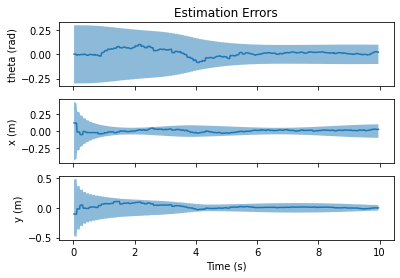

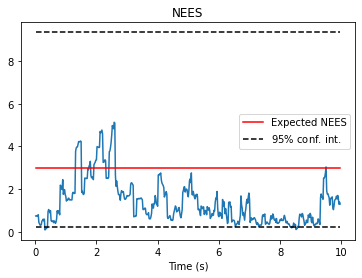

In [12]:
# First, define the filter
kalman_filter = nav.ExtendedKalmanFilter(process_model)
P0 = np.diag([0.1**2, 1**2, 1**2])  # Initial covariance
x = nav.StateWithCovariance(x, P0)  # Estimate and covariance in one container

meas_idx = 0
y = meas_data[meas_idx]
estimates = []
for k in range(len(input_data) - 1):
    u = input_data[k]

    # Fuse any measurements that have occurred.
    while y.stamp < input_data[k + 1].stamp and meas_idx < len(meas_data):
        x = kalman_filter.correct(x, y, u)

        # Load the next measurement
        meas_idx += 1
        if meas_idx < len(meas_data):
            y = meas_data[meas_idx]

    # Predict until the next input is available
    dt = input_data[k + 1].stamp - x.state.stamp
    x = kalman_filter.predict(x, u, dt)

    estimates.append(x.copy())


results = nav.GaussianResultList.from_estimates(estimates, state_data)

import matplotlib.pyplot as plt
fig, axs = nav.plot_error(results)
axs[0].set_title("Estimation Errors")
axs[0].set_ylabel("theta (rad)")
axs[1].set_ylabel("x (m)")
axs[2].set_ylabel("y (m)")
axs[2].set_xlabel("Time (s)")

fig, ax = nav.plot_nees(results)
ax.set_title("NEES")
ax.set_xlabel("Time (s)")
plt.show()

## Jacobians

TODO: In this section, we will show how to specify analytical Jacobians